# IMD3004 - Aprendizado Profundo

### Professor: Dr. Silvan Ferreira da Silva Junior

### Aluno: João Antonio Costa Paiva Chagas

## Importações

In [ ]:
import torch
import torchvision
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset

Dispositivo utilizado: cpu


## Configurações

In [ ]:
# Configuração para gráficos
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

# Configurar dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Dispositivo utilizado: {device}')

## Dados

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

## Funções auxiliares

In [ ]:
def train_mnist_model(model_class, train_loader, val_loader, epochs=20, lr=0.001, hidden_size=128):
    """Treina um modelo MNIST (dada a sua classe) e retorna o histórico de métricas."""

    model = model_class(hidden_size=hidden_size).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    history = {
        'train_losses': [], 'train_accuracies': [],
        'val_losses': [], 'val_accuracies': []
    }

    for epoch in range(epochs):
        # Treinamento
        model.train()
        train_loss, train_correct, train_total = 0.0, 0, 0

        for data, target in train_loader:
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            train_total += target.size(0)
            train_correct += (predicted == target).sum().item()

        # Avaliação no conjunto de validação
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0

        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)

                val_loss += loss.item()
                _, predicted = torch.max(output.data, 1)
                val_total += target.size(0)
                val_correct += (predicted == target).sum().item()

        # Calcular métricas da época
        history['train_losses'].append(train_loss / len(train_loader))
        history['train_accuracies'].append(100 * train_correct / train_total)
        history['val_losses'].append(val_loss / len(val_loader))
        history['val_accuracies'].append(100 * val_correct / val_total)

        if (epoch + 1) % 5 == 0:
             print(f'  Época {epoch+1}/{epochs}: '
                   f'Train Loss: {history["train_losses"][-1]:.4f}, Train Acc: {history["train_accuracies"][-1]:.2f}% | '
                   f'Val Loss: {history["val_losses"][-1]:.4f}, Val Acc: {history["val_accuracies"][-1]:.2f}%')

    return model, history

## Exercício

Usando o dataset MNIST já carregado (500 exemplos), compare três arquiteturas diferentes e identifique qual apresenta menor overfitting. Analise os gaps de loss e acurácia entre treinamento e validação.

### Arquiteturas

In [ ]:
class MNISTClassifier1(nn.Module):
    """Rede neural com duas camadas ocultas."""
    def __init__(self, hidden_size=128):
        super(MNISTClassifier1, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28 * 28, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class MNISTClassifier2(nn.Module):
    """Rede neural com 6 camadas ocultas."""
    def __init__(self, hidden_size=128):
        super(MNISTClassifier2, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28 * 28, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, hidden_size)
        self.fc5 = nn.Linear(hidden_size, hidden_size)
        self.fc6 = nn.Linear(hidden_size, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = self.fc6(x)
        return x

class MNISTClassifier3(nn.Module):
    """Rede neural com 2 camadas ocultas e Dropout para regularização."""
    def __init__(self, hidden_size=128):
        super(MNISTClassifier3, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28 * 28, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

### Treinamento

In [ ]:
arquiteturas = {
    '2 Camadas Ocultas': MNISTClassifier1,
    '6 Camadas Ocultas': MNISTClassifier2,
    '2 Camadas Ocultas + Dropout': MNISTClassifier3
}

train_size = 500
val_size = 1000
batch_size = 64
epochs = 40

val_indices = list(range(val_size))
val_dataset = Subset(train_dataset, val_indices)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

train_indices = list(range(val_size, val_size + train_size))
train_subset = Subset(train_dataset, train_indices)
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)

results_by_architecture = {}

print("=== EXPERIMENTO: EFEITO CONFIGURAÇÃO DA ARQUITETURA ===")
print(f"Tamanho do dataset de treino fixo: {train_size} exemplos")
for name, model_class in arquiteturas.items():
    print(f"\n--- Treinando arquitetura: {name} ---")

    _, history = train_mnist_model(
        model_class=model_class,
        train_loader=train_loader,
        val_loader=val_loader,
        epochs=epochs,
        lr=0.001,
        hidden_size=128
    )
    results_by_architecture[name] = history

print("\nTodos os experimentos concluídos!")

=== EXPERIMENTO: EFEITO CONFIGURAÇÃO DA ARQUITETURA ===
Tamanho do dataset de treino fixo: 500 exemplos

--- Treinando arquitetura: 2 Camadas Ocultas ---
  Época 5/40: Train Loss: 0.4814, Train Acc: 88.20% | Val Loss: 0.5472, Val Acc: 82.80%
  Época 10/40: Train Loss: 0.1259, Train Acc: 98.20% | Val Loss: 0.4266, Val Acc: 85.70%
  Época 15/40: Train Loss: 0.0394, Train Acc: 100.00% | Val Loss: 0.4371, Val Acc: 86.20%
  Época 20/40: Train Loss: 0.0128, Train Acc: 100.00% | Val Loss: 0.4547, Val Acc: 86.10%
  Época 25/40: Train Loss: 0.0067, Train Acc: 100.00% | Val Loss: 0.4709, Val Acc: 86.10%
  Época 30/40: Train Loss: 0.0042, Train Acc: 100.00% | Val Loss: 0.4886, Val Acc: 86.10%
  Época 35/40: Train Loss: 0.0029, Train Acc: 100.00% | Val Loss: 0.5010, Val Acc: 86.10%
  Época 40/40: Train Loss: 0.0022, Train Acc: 100.00% | Val Loss: 0.5128, Val Acc: 86.60%

--- Treinando arquitetura: 6 Camadas Ocultas ---
  Época 5/40: Train Loss: 0.7223, Train Acc: 74.60% | Val Loss: 0.8053, Val Acc

### Comparação Curvas

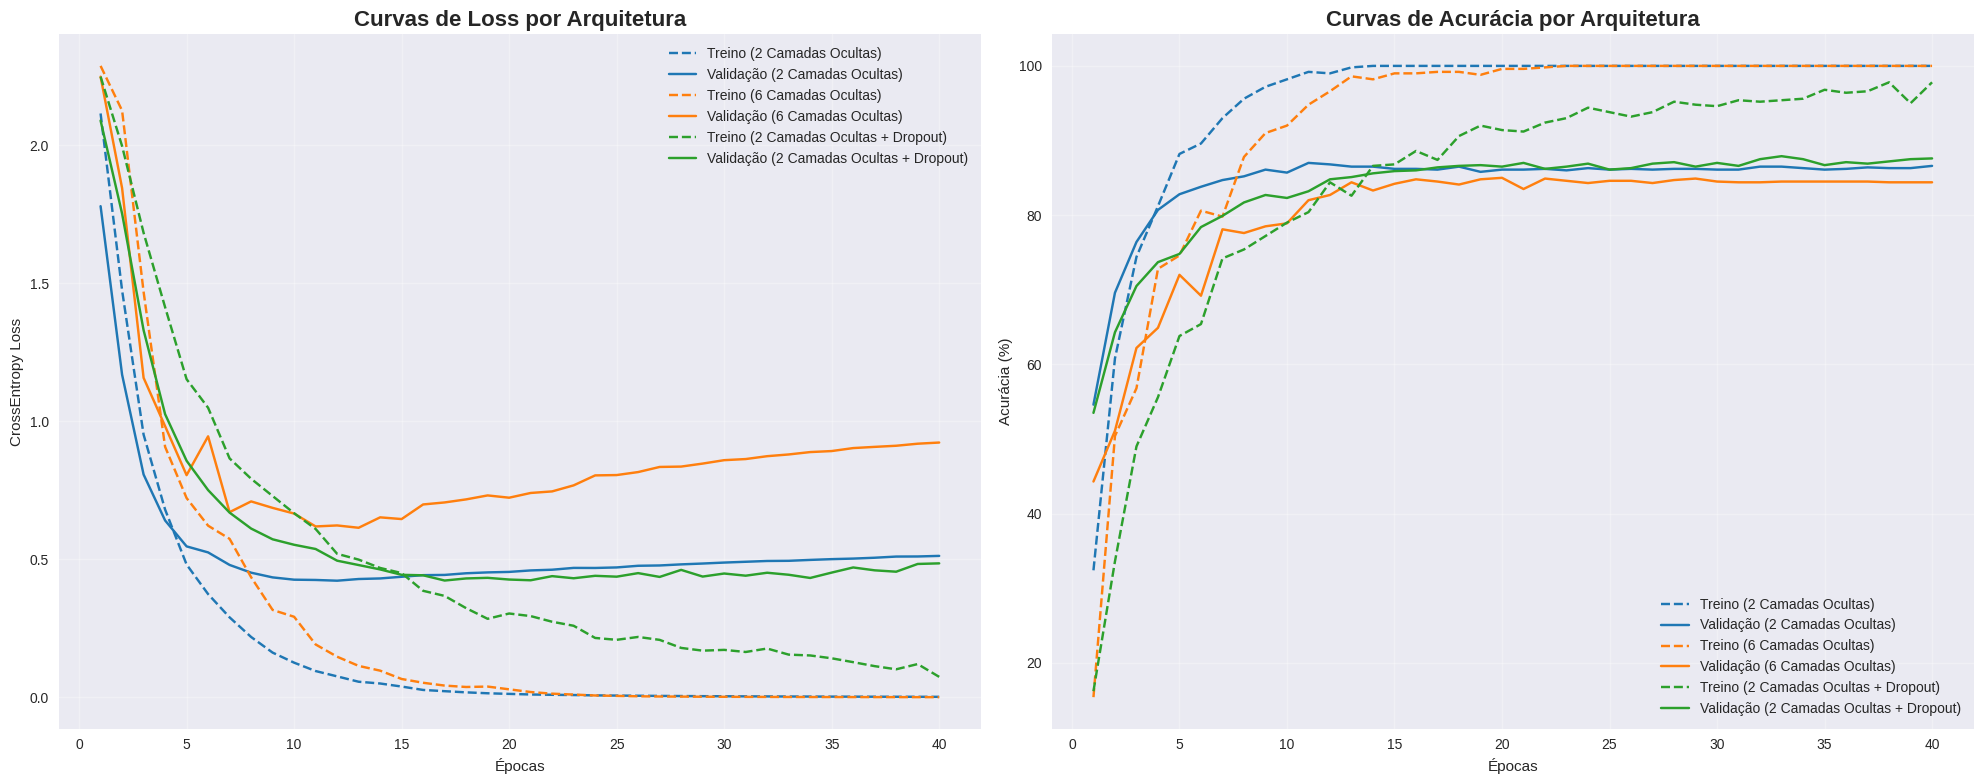

In [ ]:
fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(20, 8))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c'] # Azul, Laranja, Verde

for i, (name, history) in enumerate(results_by_architecture.items()):
    color = colors[i]
    epochs_range = range(1, len(history['train_losses']) + 1)

    # Curvas de loss
    ax_loss.plot(epochs_range, history['train_losses'], color=color, linestyle='--', label=f'Treino ({name})')
    ax_loss.plot(epochs_range, history['val_losses'], color=color, linestyle='-', label=f'Validação ({name})')

    # Curvas de acurácia
    ax_acc.plot(epochs_range, history['train_accuracies'], color=color, linestyle='--', label=f'Treino ({name})')
    ax_acc.plot(epochs_range, history['val_accuracies'], color=color, linestyle='-', label=f'Validação ({name})')

ax_loss.set_title('Curvas de Loss por Arquitetura', fontsize=16, fontweight='bold')
ax_loss.set_xlabel('Épocas'); ax_loss.set_ylabel('CrossEntropy Loss'); ax_loss.legend(); ax_loss.grid(True, alpha=0.3)
ax_acc.set_title('Curvas de Acurácia por Arquitetura', fontsize=16, fontweight='bold')
ax_acc.set_xlabel('Épocas'); ax_acc.set_ylabel('Acurácia (%)'); ax_acc.legend(); ax_acc.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Comparação Gap

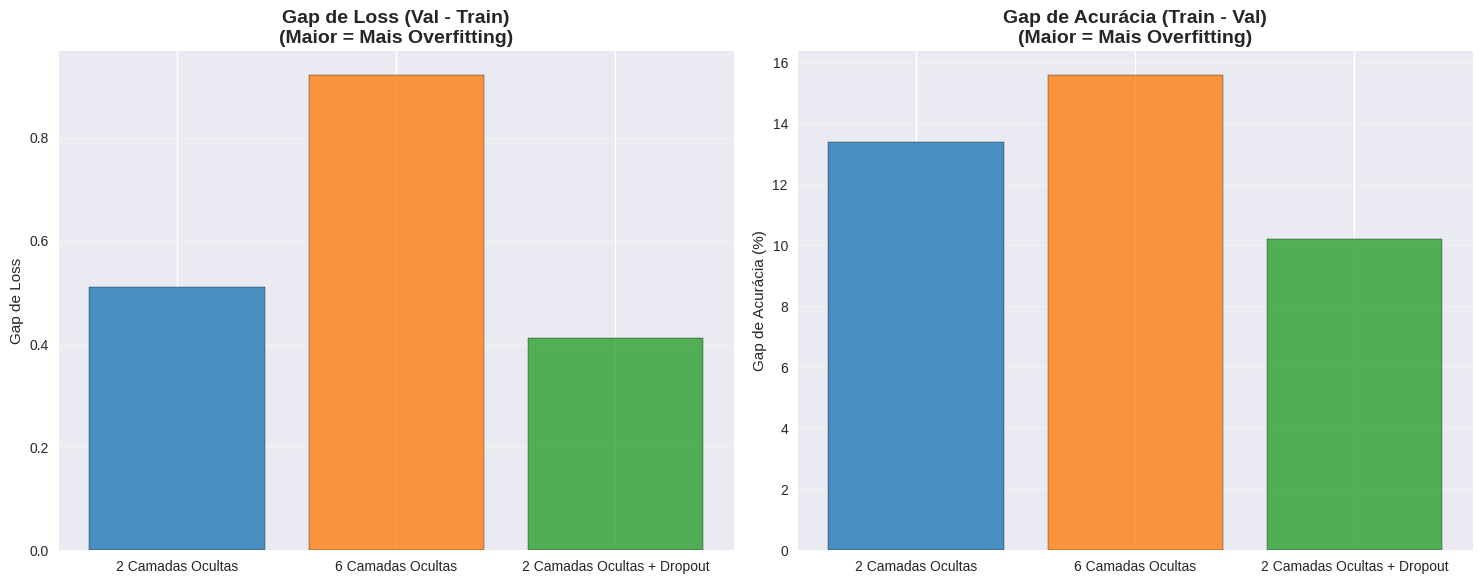

In [ ]:
# Gráfico de barras comparativo do gap por arquitetura
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
arch_names = list(results_by_architecture.keys())
loss_gaps = [res['val_losses'][-1] - res['train_losses'][-1] for res in results_by_architecture.values()]
acc_gaps = [res['train_accuracies'][-1] - res['val_accuracies'][-1] for res in results_by_architecture.values()]

# Gráfico de gap de loss
ax1.bar(arch_names, loss_gaps, color=colors, edgecolor='black', alpha=0.8)
ax1.set_title('Gap de Loss (Val - Train)\n(Maior = Mais Overfitting)', fontsize=14, fontweight='bold')
ax1.set_ylabel('Gap de Loss')
ax1.grid(True, axis='y', alpha=0.3)

# Gráfico de gap de acurácia
ax2.bar(arch_names, acc_gaps, color=colors, edgecolor='black', alpha=0.8)
ax2.set_title('Gap de Acurácia (Train - Val)\n(Maior = Mais Overfitting)', fontsize=14, fontweight='bold')
ax2.set_ylabel('Gap de Acurácia (%)')
ax2.grid(True, axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

### Resumo

In [ ]:
print("\n\n=== ANÁLISE DE OVERFITTING POR ARQUITETURA ===")
analysis_results = []
for name, history in results_by_architecture.items():
    final_train_loss = history['train_losses'][-1]
    final_val_loss = history['val_losses'][-1]
    final_train_acc = history['train_accuracies'][-1]
    final_val_acc = history['val_accuracies'][-1]
    loss_gap = final_val_loss - final_train_loss
    acc_gap = final_train_acc - final_val_acc

    analysis_results.append({
        'Arquitetura': name,
        'Loss Gap': f'{loss_gap:.4f}',
        'Acc Gap': f'{acc_gap:.2f}%',
        'Val Acc Final': f'{final_val_acc:.2f}%'
    })

df_analysis = pd.DataFrame(analysis_results)
print("TABELA RESUMO:")
print(df_analysis.to_string(index=False))



=== ANÁLISE DE OVERFITTING POR ARQUITETURA ===
TABELA RESUMO:
                Arquitetura Loss Gap Acc Gap Val Acc Final
          2 Camadas Ocultas   0.5106  13.40%        86.60%
          6 Camadas Ocultas   0.9225  15.60%        84.40%
2 Camadas Ocultas + Dropout   0.4113  10.20%        87.60%


### Conclusões

* Observações
* * A arquitetura mais complexa ("6 Camadas Ocultas") apresentou o pior desempenho no conjunto de validação (84.40%) e o maior gap de overfitting (15.60% de acurácia). Isso mostra que, na prática, simplesmente adicionar mais camadas a um modelo pode ser contraprodutivo, pois aumenta sua capacidade de memorizar os dados de treino em vez de aprender a generalizar.

* * A arquitetura que utilizou *Dropout* ("2 Camadas Ocultas + *Dropout*") obteve o melhor resultado geral. Ela alcançou a maior acurácia de validação (87.60%) e apresentou o menor gap de overfitting (10.20%). Esse resultado demonstra a utilidade de técnicas de regularização como o *Dropout*.

* * O melhor modelo não foi o mais simples nem o mais complexo, mas sim aquele que equilibrou sua capacidade de aprendizado com uma técnica de regularização. Para uma aplicação real com base nestes resultados, a arquitetura com *Dropout* seria a melhor escolha.

* Insights Teóricos
* * O modelo de 6 camadas sofre de alta variância: ele se ajusta perfeitamente aos dados de treino (baixo viés), mas falha em generalizar para os dados de validação.
* * O modelo com *Dropout* aumenta o viés (a acurácia de treino não atinge 100% tão rapidamente), mas reduz a variância, resultando num erro de generalização menor.